# PSTAT 135 Group 22: Exploratory Data Analysis

## Introduction:

The states that we chose to explore were

## Research Questions

- How does socioeconomic background (education, income, religion, etc ) affect voter turnout?
    - How does property (household, land) ownership affect voter turnouts or patterns?
    - How does education level relate to voter alignment or patterns?
    - How would age and gender relate to voter alignment or patterns?

## Import libraries and read data

In [1]:
import seaborn as sns
import pandas as pd
import pyspark.sql.functions as F
import matplotlib.pyplot as plt

In [3]:
data = 'gs://pstat135-voter-file/VM2Uniform'

In [5]:
# MI - Michigan -- Swing State
mi_df = spark.read.parquet(data + "/" + "VM2Uniform--MI--2021-01-30")

In [31]:
land_cols = ["General_2020", "Voters_Age", "Voters_Gender","County", "Voters_Active",
                    "Voters_VotingPerformanceEvenYearGeneral", "ElectionReturns_G18CountyTurnoutRepublicans",
                   "ElectionReturns_G18CountyTurnoutIndependentsAllOthers", 
                   "ElectionReturns_G18CountyTurnoutDemocrats",
                   "ElectionReturns_P18CountyTurnoutAllRegisteredVoters",
                   "ElectionReturns_G16CountyTurnoutRepublicans",
                   "ElectionReturns_G16CountyTurnoutIndependentsAllOthers", 
                   "ElectionReturns_G16CountyTurnoutDemocrats",
                   "ElectionReturns_P16CountyTurnoutAllRegisteredVoters",
                   "Residence_Addresses_Property_LandSq_Footage",
                   "Residence_Addresses_Property_HomeSq_Footage",
                    "CommercialDataLL_Gun_Owner",
                    "CommercialDataLL_Interest_in_Religious_Inspirational_In_Household",
                    "Parties_Description"
                    
                   ]
mi_df_pd = mi_df.select(*land_cols).sample(True, 0.005, 123).toPandas()

mi_df_pd = mi_df_pd.sample(10000, random_state=123)

mi_df_pd["State"] = "MI"

all_pd = mi_df_pd

all_pd['ElectionReturns_G18CountyTurnoutRepublicans'] = pd.to_numeric(all_pd['ElectionReturns_G18CountyTurnoutRepublicans'].str.replace(r'%', ''))
all_pd['ElectionReturns_G18CountyTurnoutDemocrats'] = pd.to_numeric(all_pd['ElectionReturns_G18CountyTurnoutDemocrats'].str.replace(r'%', ''))
all_pd['ElectionReturns_G16CountyTurnoutRepublicans'] = pd.to_numeric(all_pd['ElectionReturns_G16CountyTurnoutRepublicans'].str.replace(r'%', ''))
all_pd['ElectionReturns_G16CountyTurnoutDemocrats'] = pd.to_numeric(all_pd['ElectionReturns_G16CountyTurnoutDemocrats'].str.replace(r'%', ''))
all_pd["Voters_Age"] = pd.to_numeric(all_pd["Voters_Age"])
all_pd["Residence_Addresses_Property_LandSq_Footage"] = pd.to_numeric(all_pd["Residence_Addresses_Property_LandSq_Footage"])

### Property Ownership and Voter Turnout
The first idea we explored was the effect property ownership has on turnout. To do this, we selected the `Residence_Addresses_Property_LandSq_Footage` variable to see how it varies by party. 

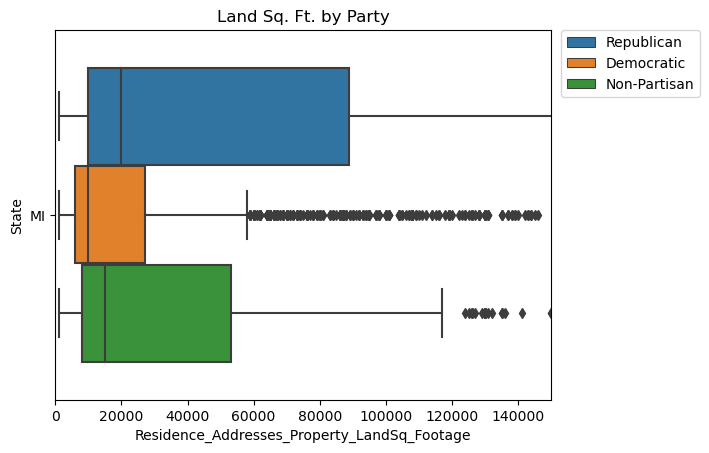

In [32]:
land_plot = sns.boxplot(data=all_pd, x="Residence_Addresses_Property_LandSq_Footage", y="State", hue="Parties_Description")
land_plot.set(title="Land Sq. Ft. by Party")
land_plot.set_xlim(0, 150000)
land_plot = plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

land_plot

This initial plot is telling us that Republicans tend to have more land in the State of Michigan. Now let's see how voter turnout differs between parties. We are interested in the presidential elections, so we are looking at voter turnout from 2016.

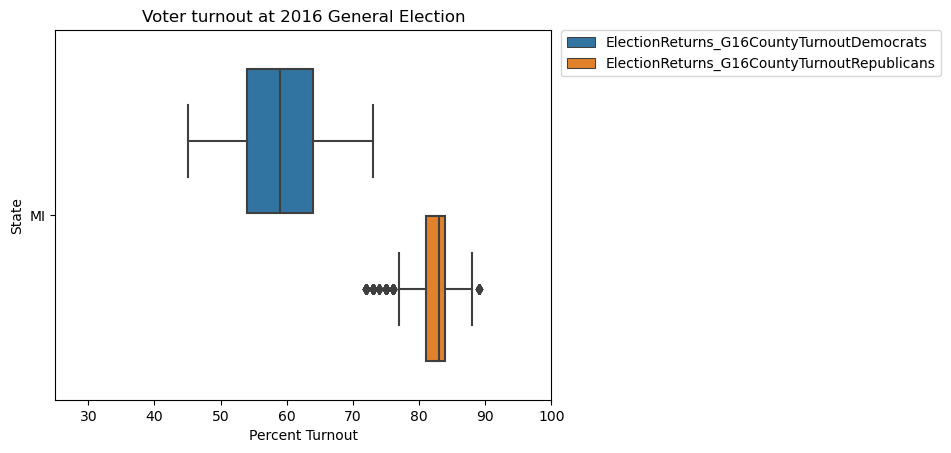

In [46]:
turnout_2016 = all_pd[["ElectionReturns_G16CountyTurnoutDemocrats", "ElectionReturns_G16CountyTurnoutRepublicans", "State"]]
turnout_2016 = pd.melt(turnout_2016, id_vars="State", value_vars=["ElectionReturns_G16CountyTurnoutDemocrats", "ElectionReturns_G16CountyTurnoutRepublicans"])

turnout_2016_plot = sns.boxplot(data=turnout_2016, x="value", y="State", hue="variable")
turnout_2016_plot.set(title="Voter turnout at 2016 General Election", xlabel="Percent Turnout")
turnout_2016_plot.set_xlim(25,100)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

In [34]:
mi_party_tot = mi_df.groupBy("Parties_Description").count().sort("Parties_Description")

mi_vote_party = mi_df.groupBy("Parties_Description", "General_2020").count().sort("Parties_Description")

mi_dem_tot = mi_party_tot.filter(mi_party_tot.Parties_Description == "Democratic").head()[1]
mi_np_tot = mi_party_tot.filter(mi_party_tot.Parties_Description == "Non-Partisan").head()[1]
mi_rep_tot = mi_party_tot.filter(mi_party_tot.Parties_Description == "Republican").head()[1]

mi_vote_party = mi_vote_party.withColumn("Total_Voted_General_2020", mi_vote_party["count"])
mi_vote_party = mi_vote_party.withColumn("Party_Total", F.when(mi_vote_party.Parties_Description == "Democratic",
                                                            mi_dem_tot)
                                                        .when(mi_vote_party.Parties_Description == "Non-Partisan",
                                                            mi_np_tot)
                                                        .when(mi_vote_party.Parties_Description == "Republican",
                                                            mi_rep_tot))

mi_vote_party = mi_vote_party.withColumn("Percent_Voted", F.round(mi_vote_party.Total_Voted_General_2020 / mi_vote_party.Party_Total, 3))
mi_vote_party = mi_vote_party.withColumn("State", F.lit("MI"))
mi_vote_party = mi_vote_party.drop("count")

mi_vote_party = mi_vote_party.filter(mi_vote_party.General_2020 == "Y").drop("General_2020")

In [28]:
mi_vote_party.show()

+-------------------+------------------------+-----------+-------------+-----+
|Parties_Description|Total_Voted_General_2020|Party_Total|Percent_Voted|State|
+-------------------+------------------------+-----------+-------------+-----+
|         Democratic|                 2894091|    4164138|        0.695|   MI|
|       Non-Partisan|                  763418|    1388458|         0.55|   MI|
|         Republican|                 1738843|    2041055|        0.852|   MI|
+-------------------+------------------------+-----------+-------------+-----+



In this swing state that is Michigan, we see about a 15% difference in the median turnout in 2018 between Democrats and Republicans. We also see Non-Partisans having the lowest percent voted at 55%. There seems to be some sort of relationship between land, party and whether or not someone voted.

## Florida EDA

In [18]:
gcs_path = 'gs://pstat135-voter-file/VM2Uniform'
numrows = dict()
print("%s: " % ('VM2Uniform--FL--2021-05-19'), end="")
    
# read dataframe for one_state
df_fl = spark.read.parquet("/".join([gcs_path, 'VM2Uniform--FL--2021-05-19']))
numrows['VM2Uniform--FL--2021-05-19'] = df_fl.count()
    
print("%d" % (numrows['VM2Uniform--FL--2021-05-19']))

VM2Uniform--FL--2021-05-19: 

14168189


In [20]:
# first pull out columns of interest
interest_cols = ["General_2020",
                 "CommercialData_Education",
                 "Voters_Age", "Voters_Gender",
                 "Residence_Addresses_Property_LandSq_Footage",
                 "Parties_Description", 
                 "CommercialData_EstimatedHHIncomeAmount"                           
]

df_sub=df_fl.select("General_2020",
                 "CommercialData_Education",
                 "Voters_Age", "Voters_Gender",
                 "Residence_Addresses_Property_LandSq_Footage",
                 "Parties_Description", 
                 "CommercialData_EstimatedHHIncomeAmount")
df_sub.printSchema()

root
 |-- General_2020: string (nullable = true)
 |-- CommercialData_Education: string (nullable = true)
 |-- Voters_Age: string (nullable = true)
 |-- Voters_Gender: string (nullable = true)
 |-- Residence_Addresses_Property_LandSq_Footage: string (nullable = true)
 |-- Parties_Description: string (nullable = true)
 |-- CommercialData_EstimatedHHIncomeAmount: string (nullable = true)



### Sample
For visualization of the data, we will need to take a sample of the data to be able to process these plots. Summaries will be done with the entire dataset to ensure the plots are what is intended.

In [17]:
# randomly take a sample of the data frame and convert to pandas
df_fl_pd = df_fl.select(*interest_cols).sample(True, 0.01, 123).toPandas()

In [21]:
# now take a 10000 subset of the pandaDF
df_fl_pd = df_fl_pd.sample(10000, random_state=123)

df_fl_pd["State"] = "FL"

df_fl_pd.head()

,General_2020,General_2016,General_2018,PresidentialPrimary_2020,PresidentialPrimary_2016,Voters_Age,Voters_Gender,County,CountyEthnic_Description,Voters_Active,...,ElectionReturns_P16CountyTurnoutAllRegisteredVoters,Residence_Addresses_Property_LandSq_Footage,Residence_Addresses_Property_HomeSq_Footage,Parties_Description,VoterParties_Change_Changed_Party,CommercialData_EstimatedHHIncome,CommercialData_AreaMedianEducationYears,CommercialDataLL_Household_Primary_Language,CommercialDataLL_Business_Owner,State
23952,Y,Y,Y,None,Y,43,F,LEE,White Self Reported,A,...,28%,0010000,02800,Republican,None,$50000-74999,12,None,None,FL
4055,None,None,None,None,None,37,F,MADISON,African or Af-Am Self Reported,A,...,39%,0217000,01200,Democratic,None,$1000-14999,12,None,None,FL
30542,Y,Y,Y,None,Y,38,M,PINELLAS,White Self Reported,A,...,27%,0008000,01300,Non-Partisan,None,$125000-149999,13,None,None,FL
17164,Y,Y,None,None,None,61,F,BROWARD,White Self Reported,A,...,16%,0007000,01300,Republican,None,$100000-124999,12,None,None,FL
25742,None,Y,Y,None,Y,84,F,SUMTER,White Self Reported,A,...,33%,None,None,Republican,None,$15000-24999,13,None,None,FL


### Age and Party

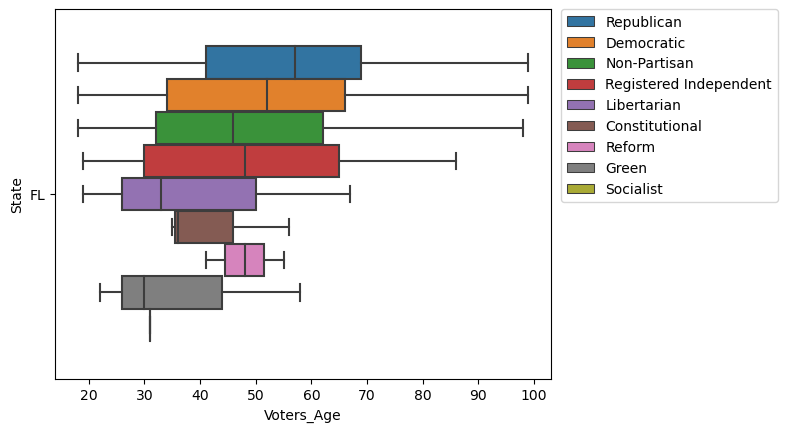

In [29]:
df_fl_pd['Voters_Age']=pd.to_numeric(df_fl_pd['Voters_Age'])

ageplot_fl = sns.boxplot(data=df_fl_pd, x="Voters_Age", y="State",hue="Parties_Description")
ageplot_fl = plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
ageplot_fl

In [30]:
ageFL = df_fl.select("Voters_Age",'Parties_Description')
ageFL.groupBy('Parties_Description').agg(F.mean('Voters_Age'), F.count('Voters_Age').alias('Voters_in_Party')).show(10)

+--------------------+------------------+---------------+
| Parties_Description|   avg(Voters_Age)|Voters_in_Party|
+--------------------+------------------+---------------+
|          Republican| 55.78978141797492|        4994235|
|Registered Indepe...| 45.94540307883206|         180523|
|               Other| 39.66997026759167|           1009|
|         Libertarian|40.406567493665804|          39863|
|               Green|39.804321404456445|           7405|
|              Reform| 50.80409556313993|           1465|
|      Constitutional|47.140307907627715|           2858|
|          Democratic|51.874933047463514|        5186510|
|           Socialist| 31.86215334420881|           1226|
|        Non-Partisan| 47.31178927220779|        3741851|
+--------------------+------------------+---------------+



## Arizona EDA

In [22]:
az_df = spark.read\
    .format("csv")\
    .option("header", "true")\
    .option("nullValue", "NA")\
    .option("delimiter", "\t")\
    .option("inferSchema", "true")\
    .parquet(data+"/VM2Uniform--AZ--2021-05-20")

In [23]:
selected_interest = [ "General_2020", "General_2016","General_2018", "PresidentialPrimary_2020","PresidentialPrimary_2016",
                 "Voters_Age", "Voters_Gender", "County", "CountyEthnic_Description", "Voters_Active", "CommercialData_EstimatedHHIncomeAmount",
                   "Voters_VotingPerformanceEvenYearGeneral", 
                   "ElectionReturns_G18CountyTurnoutRepublicans",
                   "ElectionReturns_G18CountyTurnoutIndependentsAllOthers", 
                   "ElectionReturns_G18CountyTurnoutDemocrats",
                   "ElectionReturns_P18CountyTurnoutAllRegisteredVoters",
                   "ElectionReturns_G16CountyTurnoutRepublicans",
                   "ElectionReturns_G16CountyTurnoutIndependentsAllOthers", 
                   "ElectionReturns_G16CountyTurnoutDemocrats",
                   "ElectionReturns_P16CountyTurnoutAllRegisteredVoters",
                   "Residence_Addresses_Property_LandSq_Footage",
                   "Residence_Addresses_Property_HomeSq_Footage",
                   "Parties_Description", 
                   "VoterParties_Change_Changed_Party",
                   "CommercialData_EstimatedHHIncome",
                   "CommercialData_AreaMedianEducationYears",
                   "CommercialDataLL_Household_Primary_Language",
                 "CommercialDataLL_Business_Owner",
                     "CommercialData_EstimatedAreaMedianHHIncome"
]

In [41]:
az_df_pd = az_df.select(*selected_interest).sample(True, 0.05, 123).toPandas()
az_df_pd = az_df_pd.sample(50000, random_state=123)
az_df_pd["State"] = "AZ"

In [ ]:
az_df_pd['ElectionReturns_G18CountyTurnoutRepublicans'] = pd.to_numeric(az_df_pd['ElectionReturns_G18CountyTurnoutRepublicans'].str.replace(r'%', ''))
az_df_pd['ElectionReturns_G18CountyTurnoutDemocrats'] = pd.to_numeric(az_df_pd['ElectionReturns_G18CountyTurnoutDemocrats'].str.replace(r'%', ''))
az_df_pd['ElectionReturns_G16CountyTurnoutRepublicans'] = pd.to_numeric(az_df_pd['ElectionReturns_G16CountyTurnoutRepublicans'].str.replace(r'%', ''))
az_df_pd['ElectionReturns_G16CountyTurnoutDemocrats'] = pd.to_numeric(az_df_pd['ElectionReturns_G16CountyTurnoutDemocrats'].str.replace(r'%', ''))

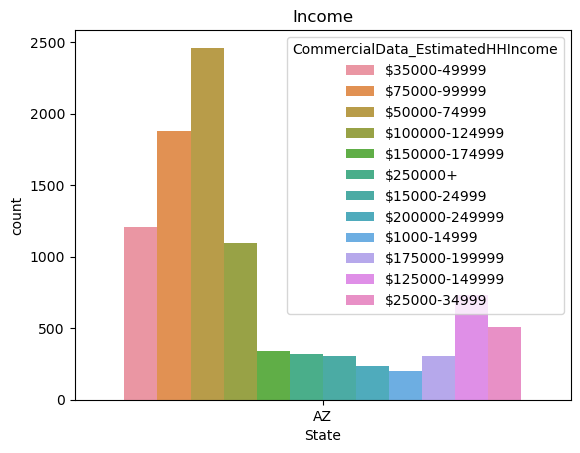

In [35]:
income_chart_az = sns.countplot(data=az_df_pd, x="State",
                             hue="CommercialData_EstimatedHHIncome").set(title="Income")



From our sample, we can see that most voters turned out to be those whose income falls in the category of 'middle-class'
This makes sense since the majority of adults in American make up the middle-class in terms of income.

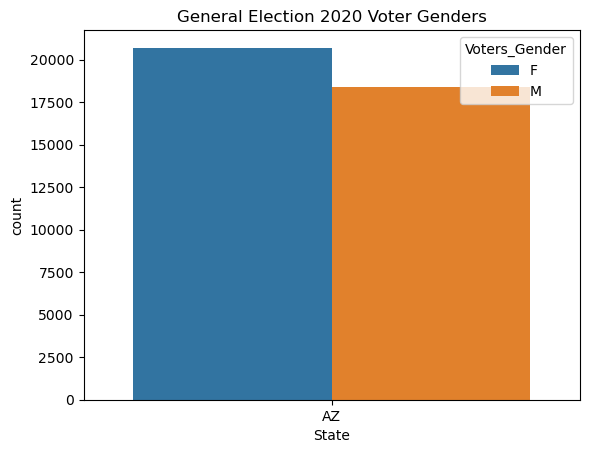

In [42]:
az_voted2020 = az_df_pd[az_df_pd["General_2020"] == "Y"]
gender_chart_az = sns.countplot(data=az_voted2020, x="State",
                             hue="Voters_Gender").set(title="2020 General Election Voters' Genders")

In our sample, we see that females were voting more than males in Arizona in the 2020 General Election. 

## Nevada

In [ ]:
### Enter Nevada EDA

# Modeling

After some exploratory analysis in these 4 swing states, we decided to use `Voters_Age`, `Voters_Gender`, `Residence_Addresses_Property_LandSq_Footage`, `Parties_Description`, `CommercialData_EstimatedHHIncomeAmount`, `CommercialData_Education` to predict `General_2020`. We will use a Logistic Regression model for each state separately then intrepret the variables to see if their are any similarities or differences in voter behaviour in swing states. With this we hope to develop a model that can predict whther or not someone will vote so that certain people or groups can be targetted.  

## Intrepretting our models